# Learning saliency for MNIST

In [27]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import sys
import datetime

import numpy as np
from skimage.filters import gaussian
from matplotlib import pyplot as plt

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense, Flatten, Multiply, Reshape, Conv2D, MaxPool2D, UpSampling2D
from keras.layers import Activation, ActivityRegularization
from keras.utils import plot_model, to_categorical
from keras.datasets import mnist
from keras.regularizers import l1, l2
from keras.losses import kld
from keras.optimizers import SGD, Adam

### Training base model to use it as base model afterwards

In [5]:
def ConvNet(train):
    if train or not os.path.isfile('classifier.hdf5'):
        print('Classifier model is being trained')
        inputs = Input([28, 28, 1])
        x = Conv2D(32, (3, 3), activation='relu', name='conv1')(inputs)
        x = Conv2D(64, (3, 3), activation='relu', name='conv2')(x)
        x = MaxPool2D((2, 2), name='mp1')(x)
        x = Conv2D(64, (3, 3), activation='relu', name='conv3')(x)
        x = Conv2D(128, (3, 3), activation='relu', name='conv4')(x)
        x = Flatten(name='flatten')(x)
        x = Dense(10, activation='softmax', name='dense1')(x)
        
        model = Model(inputs, x)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        (x_train, y_train), (x_test, y_test) = load_mnist()
        model.fit(x_train, y_train, batch_size=1000, epochs=15, validation_split=1/6)
        model.save('classifier.hdf5')
    else:
        print('Classifier model loaded')
        model = load_model('classifier.hdf5')
    return model

def load_mnist():
    # Scaling MNIST to [0.8, 1.0] allows model to assign positive saliency to black pixels
    print('Loading MNIST')
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train, -1) / 255 / 5 + 4 / 5
    x_test = np.expand_dims(x_test, -1) / 255 / 5 + 4 / 5
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    return (x_train, y_train), (x_test, y_test)

In [6]:
model = ConvNet(train=True)
(x_train, y_train), (x_test, y_test) = load_mnist()
# Fix base model
model.trainable = False

ev = model.evaluate(x_test, y_test, batch_size=6000, verbose=False)
print('Test accuracy:', ev[1])

Classifier model is being trained
Loading MNIST
Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 4s - loss: 1.4039 - acc: 0.5595 - val_loss: 0.4618 - val_acc: 0.8596
Epoch 2/15
50000/50000 [==============================] - 2s - loss: 0.4180 - acc: 0.8772 - val_loss: 0.3061 - val_acc: 0.9106
Epoch 3/15
50000/50000 [==============================] - 2s - loss: 0.2946 - acc: 0.9146 - val_loss: 0.2141 - val_acc: 0.9427
Epoch 4/15
50000/50000 [==============================] - 2s - loss: 0.2058 - acc: 0.9401 - val_loss: 0.1541 - val_acc: 0.9579
Epoch 5/15
50000/50000 [==============================] - 2s - loss: 0.1462 - acc: 0.9566 - val_loss: 0.1191 - val_acc: 0.9664
Epoch 6/15
50000/50000 [==============================] - 2s - loss: 0.1217 - acc: 0.9640 - val_loss: 0.1224 - val_acc: 0.9659
Epoch 7/15
50000/50000 [==============================] - 2s - loss: 0.1026 - acc: 0.9692 - val_loss: 0.0940 - val_acc: 0.9722
Epoch 8/15
50

0.8 1.0


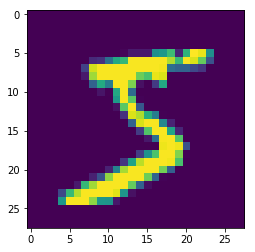

In [7]:
print(x_train.min(), x_train.max())
plt.imshow(x_train[0, :, :, 0])
plt.show()

### Building and training explanation model

In [10]:
def normalized_kld(p, q):
    # Normalized KLD is always in [0, 1]
    return 1 - K.exp(-kld(p, q))

In [8]:
def ExplanationModel(reg, train):
    if train or not os.path.isfile('exp_model.hdf5'):
        inputs = Input(shape=x_train.shape[1:])

        x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = MaxPool2D((2, 2))(x)

        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = MaxPool2D((2, 2))(x)

        x = UpSampling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

        x = UpSampling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

        x = Conv2D(1, (1, 1), activation='sigmoid', padding='same', name='attention', activity_regularizer=l2(reg))(x)
        x = Multiply()([x, inputs])
        x = model(x)

        exp_model = Model(inputs, x)

        #plot_model(exp_model, 'exp_model.png', show_shapes=True)
        y_train = model.predict(x_train)
        exp_model.compile(optimizer='adam', loss=normalized_kld)
        exp_model.summary()
        exp_model.fit(x_train, y_train, epochs=5)
        exp_model.save('exp_model.hdf5')
    else:
        exp_model = load_model('exp_model.hdf5', compile=False)
        exp_model.compile(optimizer='sgd', loss=normalized_kld)
    return exp_model

In [11]:
exp_model = ExplanationModel(reg=0.0001, train=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_9 (Conv2D)                (None, 28, 28, 32)    320         input_3[0][0]                    
____________________________________________________________________________________________________
conv2d_10 (Conv2D)               (None, 28, 28, 64)    18496       conv2d_9[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)   (None, 14, 14, 64)    0           conv2d_10[0][0]                  
___________________________________________________________________________________________

### Visualizing saliency maps

Processing image #1


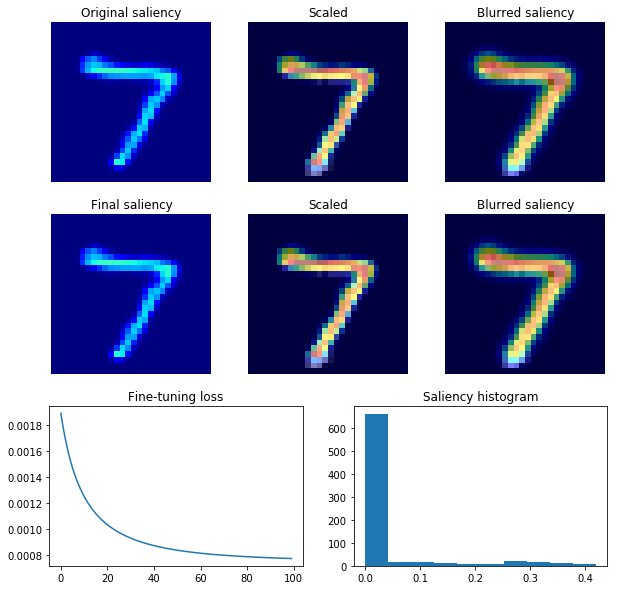

Processing image #2


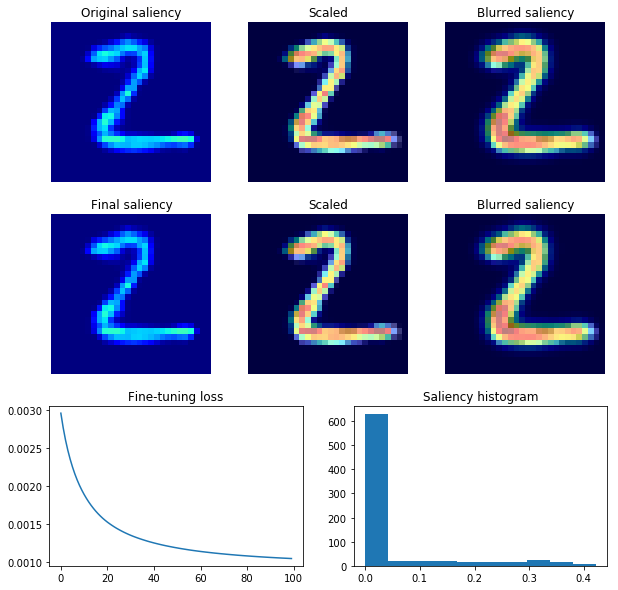

Processing image #3


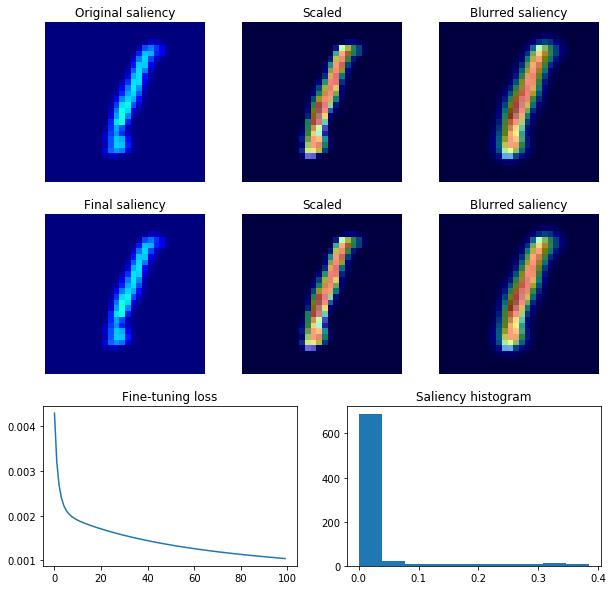

Processing image #4


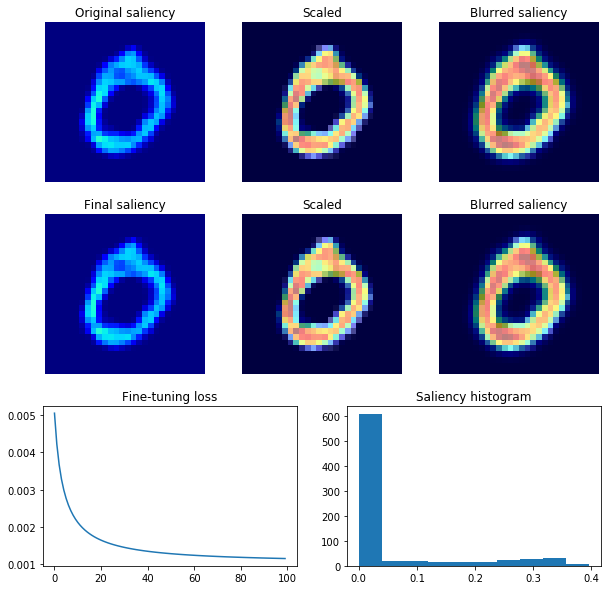

Processing image #5


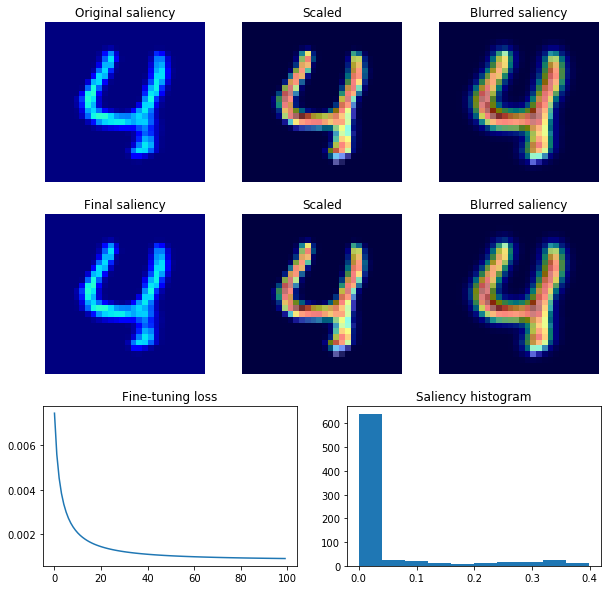

In [15]:
saliency = K.function(inputs=exp_model.inputs, outputs=[exp_model.get_layer('attention').output])

saliency_values = saliency([x_test])[0]
prediction = model.predict(x_test, batch_size=1000)
# Target distributions
y = model.predict(x_test)

for i in range(5):
    print('Processing image #{}'.format(i+1))
    exp_model = load_model('exp_model.hdf5', compile=False)
    exp_model.compile(optimizer=SGD(lr=0.01), loss=normalized_kld)
    exp_model.layers[-1].trainable = False
    saliency = K.function(inputs=exp_model.inputs, outputs=[exp_model.get_layer('attention').output])

    img = x_test[i, :, :, 0]

    plt.figure(figsize=(10, 10))
    plt.subplot(3, 3, 2)
    plt.axis('off')
    plt.title('Scaled')
    plt.imshow(img, cmap='gray')
    orig_sal = saliency_values[i].reshape((28, 28))
    sal_interp = (orig_sal - orig_sal.min()) / (orig_sal.max() - orig_sal.min())
    plt.imshow(sal_interp, alpha=0.5, cmap='jet')

    plt.subplot(3, 3, 1)
    plt.axis('off')
    plt.title('Original saliency')
    plt.imshow(orig_sal, cmap='jet', vmin=0, vmax=1)

    # Fine-tune model for individual image
    hist = exp_model.fit(x_test[i:i + 1], y[i:i + 1], epochs=100, verbose=False)
    saliency = K.function(inputs=exp_model.inputs, outputs=[exp_model.get_layer('attention').output])
    final_sal = saliency([x_test[i:i + 1]])[0].reshape((28, 28))
    final_sal_interp = (final_sal - final_sal.min()) / (final_sal.max() - final_sal.min())

    plt.subplot(3, 3, 5)
    plt.axis('off')
    plt.title('Scaled')
    plt.imshow(img, cmap='gray')
    plt.imshow(final_sal_interp, alpha=0.5, cmap='jet')

    plt.subplot(3, 3, 4)
    plt.axis('off')
    plt.title('Final saliency')
    plt.imshow(final_sal, cmap='jet', vmin=0, vmax=1)


    plt.subplot(3, 3, 3)
    plt.axis('off')
    plt.title('Blurred saliency')
    rec_field = (28 - 8) // 2
    blurred = gaussian(sal_interp, sigma=1)
    plt.imshow(img, cmap='gray')
    plt.imshow(blurred, cmap='jet', alpha=0.5)

    plt.subplot(3, 3, 6)
    plt.axis('off')
    plt.title('Blurred saliency')
    rec_field = (28 - 8) // 2
    blurred = gaussian(final_sal_interp, sigma=1)
    plt.imshow(img, cmap='gray')
    plt.imshow(blurred, cmap='jet', alpha=0.5)

    plt.subplot(3, 2, 5)
    plt.title('Fine-tuning loss')
    plt.plot(hist.history['loss'])

    plt.subplot(3, 2, 6)
    plt.title('Saliency histogram')
    plt.hist(orig_sal.flatten())

    plt.show()

In [20]:
# Raw explanations = No fine-tuning
def explain_raw(imgs, n_max=None):
    if n_max and n_max < imgs.shape[0]:
        imgs = imgs[:n_max]
    explanations = np.empty(imgs.shape[0:3])
    y = model.predict(imgs, batch_size=1000)
    
    exp_model = load_model('exp_model.hdf5', compile=False)
    opt = SGD(lr=0.001)
    exp_model.compile(optimizer=opt, loss='kld')
    saliency = K.function(inputs=exp_model.inputs, outputs=[exp_model.get_layer('attention').output])
    for i in range(imgs.shape[0]):
        if i % 1000 == 0:
            print('Processing image #{:5}/{}'.format(i+1, imgs.shape[0]))
        final_sal = saliency([x_test[i:i + 1]])[0].reshape((28, 28))
        final_sal_interp = (final_sal - final_sal.min()) / (final_sal.max() - final_sal.min())
        explanations[i] = final_sal_interp
    return explanations

In [21]:
# Explanations with fine-tuning
def explain_ft(imgs, finetune_epochs, n_max=None):
    if n_max and n_max < imgs.shape[0]:
        imgs = imgs[:n_max]
    explanations = np.empty(imgs.shape[0:3])
    y = model.predict(imgs, batch_size=1000)
    
    exp_model = load_model('exp_model.hdf5', compile=False)
    exp_model.layers[-1].trainable = False
    exp_model.compile(optimizer=SGD(lr=0.01), loss=normalized_kld)
    
    for i in range(imgs.shape[0]):
        exp_model.load_weights('exp_model.hdf5')
        exp_model.layers[-1].trainable = False
        print('Processing image #{:5}/{}'.format(i+1, imgs.shape[0]))
        hist = exp_model.fit(x_test[i:i + 1], y[i:i + 1], epochs=finetune_epochs, verbose=False)
        saliency = K.function(inputs=exp_model.inputs, outputs=[exp_model.get_layer('attention').output])
        final_sal = saliency([x_test[i:i + 1]])[0].reshape((28, 28))
        final_sal_interp = (final_sal - final_sal.min()) / (final_sal.max() - final_sal.min())
        explanations[i] = final_sal_interp
    return explanations

In [91]:
print(datetime.datetime.now())
explanations = explain_raw(x_test)
print(datetime.datetime.now())
explanations.tofile('raw_explanations2.npy')

2017-12-13 00:40:18.763521
Processing image #    1/10000
Processing image # 1001/10000
Processing image # 2001/10000
Processing image # 3001/10000
Processing image # 4001/10000
Processing image # 5001/10000
Processing image # 6001/10000
Processing image # 7001/10000
Processing image # 8001/10000
Processing image # 9001/10000
2017-12-13 00:40:28.321265


In [92]:
print(datetime.datetime.now())
explanations = explain_ft(x_test, finetune_epochs=20)
print(datetime.datetime.now())
explanations.tofile('ft20_explanations2.npy')

2017-12-13 00:40:31.139969
Processing image #    1/10000
Processing image #    2/10000
Processing image #    3/10000
Processing image #    4/10000
Processing image #    5/10000
Processing image #    6/10000
Processing image #    7/10000
Processing image #    8/10000
Processing image #    9/10000
Processing image #   10/10000
Processing image #   11/10000
Processing image #   12/10000
Processing image #   13/10000
Processing image #   14/10000
Processing image #   15/10000
Processing image #   16/10000
Processing image #   17/10000
Processing image #   18/10000
Processing image #   19/10000
Processing image #   20/10000
Processing image #   21/10000
Processing image #   22/10000
Processing image #   23/10000
Processing image #   24/10000
Processing image #   25/10000
Processing image #   26/10000
Processing image #   27/10000
Processing image #   28/10000
Processing image #   29/10000
Processing image #   30/10000
Processing image #   31/10000
Processing image #   32/10000
Processing im

Processing image #  274/10000
Processing image #  275/10000
Processing image #  276/10000
Processing image #  277/10000
Processing image #  278/10000
Processing image #  279/10000
Processing image #  280/10000
Processing image #  281/10000
Processing image #  282/10000
Processing image #  283/10000
Processing image #  284/10000
Processing image #  285/10000
Processing image #  286/10000
Processing image #  287/10000
Processing image #  288/10000
Processing image #  289/10000
Processing image #  290/10000
Processing image #  291/10000
Processing image #  292/10000
Processing image #  293/10000
Processing image #  294/10000
Processing image #  295/10000
Processing image #  296/10000
Processing image #  297/10000
Processing image #  298/10000
Processing image #  299/10000
Processing image #  300/10000
Processing image #  301/10000
Processing image #  302/10000
Processing image #  303/10000
Processing image #  304/10000
Processing image #  305/10000
Processing image #  306/10000
Processing

Processing image #  548/10000
Processing image #  549/10000
Processing image #  550/10000
Processing image #  551/10000
Processing image #  552/10000
Processing image #  553/10000
Processing image #  554/10000
Processing image #  555/10000
Processing image #  556/10000
Processing image #  557/10000
Processing image #  558/10000
Processing image #  559/10000
Processing image #  560/10000
Processing image #  561/10000
Processing image #  562/10000
Processing image #  563/10000
Processing image #  564/10000
Processing image #  565/10000
Processing image #  566/10000
Processing image #  567/10000
Processing image #  568/10000
Processing image #  569/10000
Processing image #  570/10000
Processing image #  571/10000
Processing image #  572/10000
Processing image #  573/10000
Processing image #  574/10000
Processing image #  575/10000
Processing image #  576/10000
Processing image #  577/10000
Processing image #  578/10000
Processing image #  579/10000
Processing image #  580/10000
Processing

Processing image #  822/10000
Processing image #  823/10000
Processing image #  824/10000
Processing image #  825/10000
Processing image #  826/10000
Processing image #  827/10000
Processing image #  828/10000
Processing image #  829/10000
Processing image #  830/10000
Processing image #  831/10000
Processing image #  832/10000
Processing image #  833/10000
Processing image #  834/10000
Processing image #  835/10000
Processing image #  836/10000
Processing image #  837/10000
Processing image #  838/10000
Processing image #  839/10000
Processing image #  840/10000
Processing image #  841/10000
Processing image #  842/10000
Processing image #  843/10000
Processing image #  844/10000
Processing image #  845/10000
Processing image #  846/10000
Processing image #  847/10000
Processing image #  848/10000
Processing image #  849/10000
Processing image #  850/10000
Processing image #  851/10000
Processing image #  852/10000
Processing image #  853/10000
Processing image #  854/10000
Processing

Processing image # 1096/10000
Processing image # 1097/10000
Processing image # 1098/10000
Processing image # 1099/10000
Processing image # 1100/10000
Processing image # 1101/10000
Processing image # 1102/10000
Processing image # 1103/10000
Processing image # 1104/10000
Processing image # 1105/10000
Processing image # 1106/10000
Processing image # 1107/10000
Processing image # 1108/10000
Processing image # 1109/10000
Processing image # 1110/10000
Processing image # 1111/10000
Processing image # 1112/10000
Processing image # 1113/10000
Processing image # 1114/10000
Processing image # 1115/10000
Processing image # 1116/10000
Processing image # 1117/10000
Processing image # 1118/10000
Processing image # 1119/10000
Processing image # 1120/10000
Processing image # 1121/10000
Processing image # 1122/10000
Processing image # 1123/10000
Processing image # 1124/10000
Processing image # 1125/10000
Processing image # 1126/10000
Processing image # 1127/10000
Processing image # 1128/10000
Processing

Processing image # 1370/10000
Processing image # 1371/10000
Processing image # 1372/10000
Processing image # 1373/10000
Processing image # 1374/10000
Processing image # 1375/10000
Processing image # 1376/10000
Processing image # 1377/10000
Processing image # 1378/10000
Processing image # 1379/10000
Processing image # 1380/10000
Processing image # 1381/10000
Processing image # 1382/10000
Processing image # 1383/10000
Processing image # 1384/10000
Processing image # 1385/10000
Processing image # 1386/10000
Processing image # 1387/10000
Processing image # 1388/10000
Processing image # 1389/10000
Processing image # 1390/10000
Processing image # 1391/10000
Processing image # 1392/10000
Processing image # 1393/10000
Processing image # 1394/10000
Processing image # 1395/10000
Processing image # 1396/10000
Processing image # 1397/10000
Processing image # 1398/10000
Processing image # 1399/10000
Processing image # 1400/10000
Processing image # 1401/10000
Processing image # 1402/10000
Processing

Processing image # 1644/10000
Processing image # 1645/10000
Processing image # 1646/10000
Processing image # 1647/10000
Processing image # 1648/10000
Processing image # 1649/10000
Processing image # 1650/10000
Processing image # 1651/10000
Processing image # 1652/10000
Processing image # 1653/10000
Processing image # 1654/10000
Processing image # 1655/10000
Processing image # 1656/10000
Processing image # 1657/10000
Processing image # 1658/10000
Processing image # 1659/10000
Processing image # 1660/10000
Processing image # 1661/10000
Processing image # 1662/10000
Processing image # 1663/10000
Processing image # 1664/10000
Processing image # 1665/10000
Processing image # 1666/10000
Processing image # 1667/10000
Processing image # 1668/10000
Processing image # 1669/10000
Processing image # 1670/10000
Processing image # 1671/10000
Processing image # 1672/10000
Processing image # 1673/10000
Processing image # 1674/10000
Processing image # 1675/10000
Processing image # 1676/10000
Processing

Processing image # 1918/10000
Processing image # 1919/10000
Processing image # 1920/10000
Processing image # 1921/10000
Processing image # 1922/10000
Processing image # 1923/10000
Processing image # 1924/10000
Processing image # 1925/10000
Processing image # 1926/10000
Processing image # 1927/10000
Processing image # 1928/10000
Processing image # 1929/10000
Processing image # 1930/10000
Processing image # 1931/10000
Processing image # 1932/10000
Processing image # 1933/10000
Processing image # 1934/10000
Processing image # 1935/10000
Processing image # 1936/10000
Processing image # 1937/10000
Processing image # 1938/10000
Processing image # 1939/10000
Processing image # 1940/10000
Processing image # 1941/10000
Processing image # 1942/10000
Processing image # 1943/10000
Processing image # 1944/10000
Processing image # 1945/10000
Processing image # 1946/10000
Processing image # 1947/10000
Processing image # 1948/10000
Processing image # 1949/10000
Processing image # 1950/10000
Processing

Processing image # 2192/10000
Processing image # 2193/10000
Processing image # 2194/10000
Processing image # 2195/10000
Processing image # 2196/10000
Processing image # 2197/10000
Processing image # 2198/10000
Processing image # 2199/10000
Processing image # 2200/10000
Processing image # 2201/10000
Processing image # 2202/10000
Processing image # 2203/10000
Processing image # 2204/10000
Processing image # 2205/10000
Processing image # 2206/10000
Processing image # 2207/10000
Processing image # 2208/10000
Processing image # 2209/10000
Processing image # 2210/10000
Processing image # 2211/10000
Processing image # 2212/10000
Processing image # 2213/10000
Processing image # 2214/10000
Processing image # 2215/10000
Processing image # 2216/10000
Processing image # 2217/10000
Processing image # 2218/10000
Processing image # 2219/10000
Processing image # 2220/10000
Processing image # 2221/10000
Processing image # 2222/10000
Processing image # 2223/10000
Processing image # 2224/10000
Processing

Processing image # 2466/10000
Processing image # 2467/10000
Processing image # 2468/10000
Processing image # 2469/10000
Processing image # 2470/10000
Processing image # 2471/10000
Processing image # 2472/10000
Processing image # 2473/10000
Processing image # 2474/10000
Processing image # 2475/10000
Processing image # 2476/10000
Processing image # 2477/10000
Processing image # 2478/10000
Processing image # 2479/10000
Processing image # 2480/10000
Processing image # 2481/10000
Processing image # 2482/10000
Processing image # 2483/10000
Processing image # 2484/10000
Processing image # 2485/10000
Processing image # 2486/10000
Processing image # 2487/10000
Processing image # 2488/10000
Processing image # 2489/10000
Processing image # 2490/10000
Processing image # 2491/10000
Processing image # 2492/10000
Processing image # 2493/10000
Processing image # 2494/10000
Processing image # 2495/10000
Processing image # 2496/10000
Processing image # 2497/10000
Processing image # 2498/10000
Processing

Processing image # 2740/10000
Processing image # 2741/10000
Processing image # 2742/10000
Processing image # 2743/10000
Processing image # 2744/10000
Processing image # 2745/10000
Processing image # 2746/10000
Processing image # 2747/10000
Processing image # 2748/10000
Processing image # 2749/10000
Processing image # 2750/10000
Processing image # 2751/10000
Processing image # 2752/10000
Processing image # 2753/10000
Processing image # 2754/10000
Processing image # 2755/10000
Processing image # 2756/10000
Processing image # 2757/10000
Processing image # 2758/10000
Processing image # 2759/10000
Processing image # 2760/10000
Processing image # 2761/10000
Processing image # 2762/10000
Processing image # 2763/10000
Processing image # 2764/10000
Processing image # 2765/10000
Processing image # 2766/10000
Processing image # 2767/10000
Processing image # 2768/10000
Processing image # 2769/10000
Processing image # 2770/10000
Processing image # 2771/10000
Processing image # 2772/10000
Processing

Processing image # 3014/10000
Processing image # 3015/10000
Processing image # 3016/10000
Processing image # 3017/10000
Processing image # 3018/10000
Processing image # 3019/10000
Processing image # 3020/10000
Processing image # 3021/10000
Processing image # 3022/10000
Processing image # 3023/10000
Processing image # 3024/10000
Processing image # 3025/10000
Processing image # 3026/10000
Processing image # 3027/10000
Processing image # 3028/10000
Processing image # 3029/10000
Processing image # 3030/10000
Processing image # 3031/10000
Processing image # 3032/10000
Processing image # 3033/10000
Processing image # 3034/10000
Processing image # 3035/10000
Processing image # 3036/10000
Processing image # 3037/10000
Processing image # 3038/10000
Processing image # 3039/10000
Processing image # 3040/10000
Processing image # 3041/10000
Processing image # 3042/10000
Processing image # 3043/10000
Processing image # 3044/10000
Processing image # 3045/10000
Processing image # 3046/10000
Processing

Processing image # 3288/10000
Processing image # 3289/10000
Processing image # 3290/10000
Processing image # 3291/10000
Processing image # 3292/10000
Processing image # 3293/10000
Processing image # 3294/10000
Processing image # 3295/10000
Processing image # 3296/10000
Processing image # 3297/10000
Processing image # 3298/10000
Processing image # 3299/10000
Processing image # 3300/10000
Processing image # 3301/10000
Processing image # 3302/10000
Processing image # 3303/10000
Processing image # 3304/10000
Processing image # 3305/10000
Processing image # 3306/10000
Processing image # 3307/10000
Processing image # 3308/10000
Processing image # 3309/10000
Processing image # 3310/10000
Processing image # 3311/10000
Processing image # 3312/10000
Processing image # 3313/10000
Processing image # 3314/10000
Processing image # 3315/10000
Processing image # 3316/10000
Processing image # 3317/10000
Processing image # 3318/10000
Processing image # 3319/10000
Processing image # 3320/10000
Processing

Processing image # 3562/10000
Processing image # 3563/10000
Processing image # 3564/10000
Processing image # 3565/10000
Processing image # 3566/10000
Processing image # 3567/10000
Processing image # 3568/10000
Processing image # 3569/10000
Processing image # 3570/10000
Processing image # 3571/10000
Processing image # 3572/10000
Processing image # 3573/10000
Processing image # 3574/10000
Processing image # 3575/10000
Processing image # 3576/10000
Processing image # 3577/10000
Processing image # 3578/10000
Processing image # 3579/10000
Processing image # 3580/10000
Processing image # 3581/10000
Processing image # 3582/10000
Processing image # 3583/10000
Processing image # 3584/10000
Processing image # 3585/10000
Processing image # 3586/10000
Processing image # 3587/10000
Processing image # 3588/10000
Processing image # 3589/10000
Processing image # 3590/10000
Processing image # 3591/10000
Processing image # 3592/10000
Processing image # 3593/10000
Processing image # 3594/10000
Processing

Processing image # 3836/10000
Processing image # 3837/10000
Processing image # 3838/10000
Processing image # 3839/10000
Processing image # 3840/10000
Processing image # 3841/10000
Processing image # 3842/10000
Processing image # 3843/10000
Processing image # 3844/10000
Processing image # 3845/10000
Processing image # 3846/10000
Processing image # 3847/10000
Processing image # 3848/10000
Processing image # 3849/10000
Processing image # 3850/10000
Processing image # 3851/10000
Processing image # 3852/10000
Processing image # 3853/10000
Processing image # 3854/10000
Processing image # 3855/10000
Processing image # 3856/10000
Processing image # 3857/10000
Processing image # 3858/10000
Processing image # 3859/10000
Processing image # 3860/10000
Processing image # 3861/10000
Processing image # 3862/10000
Processing image # 3863/10000
Processing image # 3864/10000
Processing image # 3865/10000
Processing image # 3866/10000
Processing image # 3867/10000
Processing image # 3868/10000
Processing

Processing image # 4110/10000
Processing image # 4111/10000
Processing image # 4112/10000
Processing image # 4113/10000
Processing image # 4114/10000
Processing image # 4115/10000
Processing image # 4116/10000
Processing image # 4117/10000
Processing image # 4118/10000
Processing image # 4119/10000
Processing image # 4120/10000
Processing image # 4121/10000
Processing image # 4122/10000
Processing image # 4123/10000
Processing image # 4124/10000
Processing image # 4125/10000
Processing image # 4126/10000
Processing image # 4127/10000
Processing image # 4128/10000
Processing image # 4129/10000
Processing image # 4130/10000
Processing image # 4131/10000
Processing image # 4132/10000
Processing image # 4133/10000
Processing image # 4134/10000
Processing image # 4135/10000
Processing image # 4136/10000
Processing image # 4137/10000
Processing image # 4138/10000
Processing image # 4139/10000
Processing image # 4140/10000
Processing image # 4141/10000
Processing image # 4142/10000
Processing

Processing image # 4384/10000
Processing image # 4385/10000
Processing image # 4386/10000
Processing image # 4387/10000
Processing image # 4388/10000
Processing image # 4389/10000
Processing image # 4390/10000
Processing image # 4391/10000
Processing image # 4392/10000
Processing image # 4393/10000
Processing image # 4394/10000
Processing image # 4395/10000
Processing image # 4396/10000
Processing image # 4397/10000
Processing image # 4398/10000
Processing image # 4399/10000
Processing image # 4400/10000
Processing image # 4401/10000
Processing image # 4402/10000
Processing image # 4403/10000
Processing image # 4404/10000
Processing image # 4405/10000
Processing image # 4406/10000
Processing image # 4407/10000
Processing image # 4408/10000
Processing image # 4409/10000
Processing image # 4410/10000
Processing image # 4411/10000
Processing image # 4412/10000
Processing image # 4413/10000
Processing image # 4414/10000
Processing image # 4415/10000
Processing image # 4416/10000
Processing

Processing image # 4658/10000
Processing image # 4659/10000
Processing image # 4660/10000
Processing image # 4661/10000
Processing image # 4662/10000
Processing image # 4663/10000
Processing image # 4664/10000
Processing image # 4665/10000
Processing image # 4666/10000
Processing image # 4667/10000
Processing image # 4668/10000
Processing image # 4669/10000
Processing image # 4670/10000
Processing image # 4671/10000
Processing image # 4672/10000
Processing image # 4673/10000
Processing image # 4674/10000
Processing image # 4675/10000
Processing image # 4676/10000
Processing image # 4677/10000
Processing image # 4678/10000
Processing image # 4679/10000
Processing image # 4680/10000
Processing image # 4681/10000
Processing image # 4682/10000
Processing image # 4683/10000
Processing image # 4684/10000
Processing image # 4685/10000
Processing image # 4686/10000
Processing image # 4687/10000
Processing image # 4688/10000
Processing image # 4689/10000
Processing image # 4690/10000
Processing

Processing image # 4932/10000
Processing image # 4933/10000
Processing image # 4934/10000
Processing image # 4935/10000
Processing image # 4936/10000
Processing image # 4937/10000
Processing image # 4938/10000
Processing image # 4939/10000
Processing image # 4940/10000
Processing image # 4941/10000
Processing image # 4942/10000
Processing image # 4943/10000
Processing image # 4944/10000
Processing image # 4945/10000
Processing image # 4946/10000
Processing image # 4947/10000
Processing image # 4948/10000
Processing image # 4949/10000
Processing image # 4950/10000
Processing image # 4951/10000
Processing image # 4952/10000
Processing image # 4953/10000
Processing image # 4954/10000
Processing image # 4955/10000
Processing image # 4956/10000
Processing image # 4957/10000
Processing image # 4958/10000
Processing image # 4959/10000
Processing image # 4960/10000
Processing image # 4961/10000
Processing image # 4962/10000
Processing image # 4963/10000
Processing image # 4964/10000
Processing

Processing image # 5206/10000
Processing image # 5207/10000
Processing image # 5208/10000
Processing image # 5209/10000
Processing image # 5210/10000
Processing image # 5211/10000
Processing image # 5212/10000
Processing image # 5213/10000
Processing image # 5214/10000
Processing image # 5215/10000
Processing image # 5216/10000
Processing image # 5217/10000
Processing image # 5218/10000
Processing image # 5219/10000
Processing image # 5220/10000
Processing image # 5221/10000
Processing image # 5222/10000
Processing image # 5223/10000
Processing image # 5224/10000
Processing image # 5225/10000
Processing image # 5226/10000
Processing image # 5227/10000
Processing image # 5228/10000
Processing image # 5229/10000
Processing image # 5230/10000
Processing image # 5231/10000
Processing image # 5232/10000
Processing image # 5233/10000
Processing image # 5234/10000
Processing image # 5235/10000
Processing image # 5236/10000
Processing image # 5237/10000
Processing image # 5238/10000
Processing

Processing image # 5480/10000
Processing image # 5481/10000
Processing image # 5482/10000
Processing image # 5483/10000
Processing image # 5484/10000
Processing image # 5485/10000
Processing image # 5486/10000
Processing image # 5487/10000
Processing image # 5488/10000
Processing image # 5489/10000
Processing image # 5490/10000
Processing image # 5491/10000
Processing image # 5492/10000
Processing image # 5493/10000
Processing image # 5494/10000
Processing image # 5495/10000
Processing image # 5496/10000
Processing image # 5497/10000
Processing image # 5498/10000
Processing image # 5499/10000
Processing image # 5500/10000
Processing image # 5501/10000
Processing image # 5502/10000
Processing image # 5503/10000
Processing image # 5504/10000
Processing image # 5505/10000
Processing image # 5506/10000
Processing image # 5507/10000
Processing image # 5508/10000
Processing image # 5509/10000
Processing image # 5510/10000
Processing image # 5511/10000
Processing image # 5512/10000
Processing

Processing image # 5754/10000
Processing image # 5755/10000
Processing image # 5756/10000
Processing image # 5757/10000
Processing image # 5758/10000
Processing image # 5759/10000
Processing image # 5760/10000
Processing image # 5761/10000
Processing image # 5762/10000
Processing image # 5763/10000
Processing image # 5764/10000
Processing image # 5765/10000
Processing image # 5766/10000
Processing image # 5767/10000
Processing image # 5768/10000
Processing image # 5769/10000
Processing image # 5770/10000
Processing image # 5771/10000
Processing image # 5772/10000
Processing image # 5773/10000
Processing image # 5774/10000
Processing image # 5775/10000
Processing image # 5776/10000
Processing image # 5777/10000
Processing image # 5778/10000
Processing image # 5779/10000
Processing image # 5780/10000
Processing image # 5781/10000
Processing image # 5782/10000
Processing image # 5783/10000
Processing image # 5784/10000
Processing image # 5785/10000
Processing image # 5786/10000
Processing

Processing image # 6028/10000
Processing image # 6029/10000
Processing image # 6030/10000
Processing image # 6031/10000
Processing image # 6032/10000
Processing image # 6033/10000
Processing image # 6034/10000
Processing image # 6035/10000
Processing image # 6036/10000
Processing image # 6037/10000
Processing image # 6038/10000
Processing image # 6039/10000
Processing image # 6040/10000
Processing image # 6041/10000
Processing image # 6042/10000
Processing image # 6043/10000
Processing image # 6044/10000
Processing image # 6045/10000
Processing image # 6046/10000
Processing image # 6047/10000
Processing image # 6048/10000
Processing image # 6049/10000
Processing image # 6050/10000
Processing image # 6051/10000
Processing image # 6052/10000
Processing image # 6053/10000
Processing image # 6054/10000
Processing image # 6055/10000
Processing image # 6056/10000
Processing image # 6057/10000
Processing image # 6058/10000
Processing image # 6059/10000
Processing image # 6060/10000
Processing

Processing image # 6302/10000
Processing image # 6303/10000
Processing image # 6304/10000
Processing image # 6305/10000
Processing image # 6306/10000
Processing image # 6307/10000
Processing image # 6308/10000
Processing image # 6309/10000
Processing image # 6310/10000
Processing image # 6311/10000
Processing image # 6312/10000
Processing image # 6313/10000
Processing image # 6314/10000
Processing image # 6315/10000
Processing image # 6316/10000
Processing image # 6317/10000
Processing image # 6318/10000
Processing image # 6319/10000
Processing image # 6320/10000
Processing image # 6321/10000
Processing image # 6322/10000
Processing image # 6323/10000
Processing image # 6324/10000
Processing image # 6325/10000
Processing image # 6326/10000
Processing image # 6327/10000
Processing image # 6328/10000
Processing image # 6329/10000
Processing image # 6330/10000
Processing image # 6331/10000
Processing image # 6332/10000
Processing image # 6333/10000
Processing image # 6334/10000
Processing

Processing image # 6576/10000
Processing image # 6577/10000
Processing image # 6578/10000
Processing image # 6579/10000
Processing image # 6580/10000
Processing image # 6581/10000
Processing image # 6582/10000
Processing image # 6583/10000
Processing image # 6584/10000
Processing image # 6585/10000
Processing image # 6586/10000
Processing image # 6587/10000
Processing image # 6588/10000
Processing image # 6589/10000
Processing image # 6590/10000
Processing image # 6591/10000
Processing image # 6592/10000
Processing image # 6593/10000
Processing image # 6594/10000
Processing image # 6595/10000
Processing image # 6596/10000
Processing image # 6597/10000
Processing image # 6598/10000
Processing image # 6599/10000
Processing image # 6600/10000
Processing image # 6601/10000
Processing image # 6602/10000
Processing image # 6603/10000
Processing image # 6604/10000
Processing image # 6605/10000
Processing image # 6606/10000
Processing image # 6607/10000
Processing image # 6608/10000
Processing

Processing image # 6850/10000
Processing image # 6851/10000
Processing image # 6852/10000
Processing image # 6853/10000
Processing image # 6854/10000
Processing image # 6855/10000
Processing image # 6856/10000
Processing image # 6857/10000
Processing image # 6858/10000
Processing image # 6859/10000
Processing image # 6860/10000
Processing image # 6861/10000
Processing image # 6862/10000
Processing image # 6863/10000
Processing image # 6864/10000
Processing image # 6865/10000
Processing image # 6866/10000
Processing image # 6867/10000
Processing image # 6868/10000
Processing image # 6869/10000
Processing image # 6870/10000
Processing image # 6871/10000
Processing image # 6872/10000
Processing image # 6873/10000
Processing image # 6874/10000
Processing image # 6875/10000
Processing image # 6876/10000
Processing image # 6877/10000
Processing image # 6878/10000
Processing image # 6879/10000
Processing image # 6880/10000
Processing image # 6881/10000
Processing image # 6882/10000
Processing

Processing image # 7124/10000
Processing image # 7125/10000
Processing image # 7126/10000
Processing image # 7127/10000
Processing image # 7128/10000
Processing image # 7129/10000
Processing image # 7130/10000
Processing image # 7131/10000
Processing image # 7132/10000
Processing image # 7133/10000
Processing image # 7134/10000
Processing image # 7135/10000
Processing image # 7136/10000
Processing image # 7137/10000
Processing image # 7138/10000
Processing image # 7139/10000
Processing image # 7140/10000
Processing image # 7141/10000
Processing image # 7142/10000
Processing image # 7143/10000
Processing image # 7144/10000
Processing image # 7145/10000
Processing image # 7146/10000
Processing image # 7147/10000
Processing image # 7148/10000
Processing image # 7149/10000
Processing image # 7150/10000
Processing image # 7151/10000
Processing image # 7152/10000
Processing image # 7153/10000
Processing image # 7154/10000
Processing image # 7155/10000
Processing image # 7156/10000
Processing

Processing image # 7398/10000
Processing image # 7399/10000
Processing image # 7400/10000
Processing image # 7401/10000
Processing image # 7402/10000
Processing image # 7403/10000
Processing image # 7404/10000
Processing image # 7405/10000
Processing image # 7406/10000
Processing image # 7407/10000
Processing image # 7408/10000
Processing image # 7409/10000
Processing image # 7410/10000
Processing image # 7411/10000
Processing image # 7412/10000
Processing image # 7413/10000
Processing image # 7414/10000
Processing image # 7415/10000
Processing image # 7416/10000
Processing image # 7417/10000
Processing image # 7418/10000
Processing image # 7419/10000
Processing image # 7420/10000
Processing image # 7421/10000
Processing image # 7422/10000
Processing image # 7423/10000
Processing image # 7424/10000
Processing image # 7425/10000
Processing image # 7426/10000
Processing image # 7427/10000
Processing image # 7428/10000
Processing image # 7429/10000
Processing image # 7430/10000
Processing

Processing image # 7672/10000
Processing image # 7673/10000
Processing image # 7674/10000
Processing image # 7675/10000
Processing image # 7676/10000
Processing image # 7677/10000
Processing image # 7678/10000
Processing image # 7679/10000
Processing image # 7680/10000
Processing image # 7681/10000
Processing image # 7682/10000
Processing image # 7683/10000
Processing image # 7684/10000
Processing image # 7685/10000
Processing image # 7686/10000
Processing image # 7687/10000
Processing image # 7688/10000
Processing image # 7689/10000
Processing image # 7690/10000
Processing image # 7691/10000
Processing image # 7692/10000
Processing image # 7693/10000
Processing image # 7694/10000
Processing image # 7695/10000
Processing image # 7696/10000
Processing image # 7697/10000
Processing image # 7698/10000
Processing image # 7699/10000
Processing image # 7700/10000
Processing image # 7701/10000
Processing image # 7702/10000
Processing image # 7703/10000
Processing image # 7704/10000
Processing

Processing image # 7946/10000
Processing image # 7947/10000
Processing image # 7948/10000
Processing image # 7949/10000
Processing image # 7950/10000
Processing image # 7951/10000
Processing image # 7952/10000
Processing image # 7953/10000
Processing image # 7954/10000
Processing image # 7955/10000
Processing image # 7956/10000
Processing image # 7957/10000
Processing image # 7958/10000
Processing image # 7959/10000
Processing image # 7960/10000
Processing image # 7961/10000
Processing image # 7962/10000
Processing image # 7963/10000
Processing image # 7964/10000
Processing image # 7965/10000
Processing image # 7966/10000
Processing image # 7967/10000
Processing image # 7968/10000
Processing image # 7969/10000
Processing image # 7970/10000
Processing image # 7971/10000
Processing image # 7972/10000
Processing image # 7973/10000
Processing image # 7974/10000
Processing image # 7975/10000
Processing image # 7976/10000
Processing image # 7977/10000
Processing image # 7978/10000
Processing

Processing image # 8220/10000
Processing image # 8221/10000
Processing image # 8222/10000
Processing image # 8223/10000
Processing image # 8224/10000
Processing image # 8225/10000
Processing image # 8226/10000
Processing image # 8227/10000
Processing image # 8228/10000
Processing image # 8229/10000
Processing image # 8230/10000
Processing image # 8231/10000
Processing image # 8232/10000
Processing image # 8233/10000
Processing image # 8234/10000
Processing image # 8235/10000
Processing image # 8236/10000
Processing image # 8237/10000
Processing image # 8238/10000
Processing image # 8239/10000
Processing image # 8240/10000
Processing image # 8241/10000
Processing image # 8242/10000
Processing image # 8243/10000
Processing image # 8244/10000
Processing image # 8245/10000
Processing image # 8246/10000
Processing image # 8247/10000
Processing image # 8248/10000
Processing image # 8249/10000
Processing image # 8250/10000
Processing image # 8251/10000
Processing image # 8252/10000
Processing

Processing image # 8494/10000
Processing image # 8495/10000
Processing image # 8496/10000
Processing image # 8497/10000
Processing image # 8498/10000
Processing image # 8499/10000
Processing image # 8500/10000
Processing image # 8501/10000
Processing image # 8502/10000
Processing image # 8503/10000
Processing image # 8504/10000
Processing image # 8505/10000
Processing image # 8506/10000
Processing image # 8507/10000
Processing image # 8508/10000
Processing image # 8509/10000
Processing image # 8510/10000
Processing image # 8511/10000
Processing image # 8512/10000
Processing image # 8513/10000
Processing image # 8514/10000
Processing image # 8515/10000
Processing image # 8516/10000
Processing image # 8517/10000
Processing image # 8518/10000
Processing image # 8519/10000
Processing image # 8520/10000
Processing image # 8521/10000
Processing image # 8522/10000
Processing image # 8523/10000
Processing image # 8524/10000
Processing image # 8525/10000
Processing image # 8526/10000
Processing

Processing image # 8768/10000
Processing image # 8769/10000
Processing image # 8770/10000
Processing image # 8771/10000
Processing image # 8772/10000
Processing image # 8773/10000
Processing image # 8774/10000
Processing image # 8775/10000
Processing image # 8776/10000
Processing image # 8777/10000
Processing image # 8778/10000
Processing image # 8779/10000
Processing image # 8780/10000
Processing image # 8781/10000
Processing image # 8782/10000
Processing image # 8783/10000
Processing image # 8784/10000
Processing image # 8785/10000
Processing image # 8786/10000
Processing image # 8787/10000
Processing image # 8788/10000
Processing image # 8789/10000
Processing image # 8790/10000
Processing image # 8791/10000
Processing image # 8792/10000
Processing image # 8793/10000
Processing image # 8794/10000
Processing image # 8795/10000
Processing image # 8796/10000
Processing image # 8797/10000
Processing image # 8798/10000
Processing image # 8799/10000
Processing image # 8800/10000
Processing

Processing image # 9042/10000
Processing image # 9043/10000
Processing image # 9044/10000
Processing image # 9045/10000
Processing image # 9046/10000
Processing image # 9047/10000
Processing image # 9048/10000
Processing image # 9049/10000
Processing image # 9050/10000
Processing image # 9051/10000
Processing image # 9052/10000
Processing image # 9053/10000
Processing image # 9054/10000
Processing image # 9055/10000
Processing image # 9056/10000
Processing image # 9057/10000
Processing image # 9058/10000
Processing image # 9059/10000
Processing image # 9060/10000
Processing image # 9061/10000
Processing image # 9062/10000
Processing image # 9063/10000
Processing image # 9064/10000
Processing image # 9065/10000
Processing image # 9066/10000
Processing image # 9067/10000
Processing image # 9068/10000
Processing image # 9069/10000
Processing image # 9070/10000
Processing image # 9071/10000
Processing image # 9072/10000
Processing image # 9073/10000
Processing image # 9074/10000
Processing

Processing image # 9316/10000
Processing image # 9317/10000
Processing image # 9318/10000
Processing image # 9319/10000
Processing image # 9320/10000
Processing image # 9321/10000
Processing image # 9322/10000
Processing image # 9323/10000
Processing image # 9324/10000
Processing image # 9325/10000
Processing image # 9326/10000
Processing image # 9327/10000
Processing image # 9328/10000
Processing image # 9329/10000
Processing image # 9330/10000
Processing image # 9331/10000
Processing image # 9332/10000
Processing image # 9333/10000
Processing image # 9334/10000
Processing image # 9335/10000
Processing image # 9336/10000
Processing image # 9337/10000
Processing image # 9338/10000
Processing image # 9339/10000
Processing image # 9340/10000
Processing image # 9341/10000
Processing image # 9342/10000
Processing image # 9343/10000
Processing image # 9344/10000
Processing image # 9345/10000
Processing image # 9346/10000
Processing image # 9347/10000
Processing image # 9348/10000
Processing

Processing image # 9590/10000
Processing image # 9591/10000
Processing image # 9592/10000
Processing image # 9593/10000
Processing image # 9594/10000
Processing image # 9595/10000
Processing image # 9596/10000
Processing image # 9597/10000
Processing image # 9598/10000
Processing image # 9599/10000
Processing image # 9600/10000
Processing image # 9601/10000
Processing image # 9602/10000
Processing image # 9603/10000
Processing image # 9604/10000
Processing image # 9605/10000
Processing image # 9606/10000
Processing image # 9607/10000
Processing image # 9608/10000
Processing image # 9609/10000
Processing image # 9610/10000
Processing image # 9611/10000
Processing image # 9612/10000
Processing image # 9613/10000
Processing image # 9614/10000
Processing image # 9615/10000
Processing image # 9616/10000
Processing image # 9617/10000
Processing image # 9618/10000
Processing image # 9619/10000
Processing image # 9620/10000
Processing image # 9621/10000
Processing image # 9622/10000
Processing

Processing image # 9864/10000
Processing image # 9865/10000
Processing image # 9866/10000
Processing image # 9867/10000
Processing image # 9868/10000
Processing image # 9869/10000
Processing image # 9870/10000
Processing image # 9871/10000
Processing image # 9872/10000
Processing image # 9873/10000
Processing image # 9874/10000
Processing image # 9875/10000
Processing image # 9876/10000
Processing image # 9877/10000
Processing image # 9878/10000
Processing image # 9879/10000
Processing image # 9880/10000
Processing image # 9881/10000
Processing image # 9882/10000
Processing image # 9883/10000
Processing image # 9884/10000
Processing image # 9885/10000
Processing image # 9886/10000
Processing image # 9887/10000
Processing image # 9888/10000
Processing image # 9889/10000
Processing image # 9890/10000
Processing image # 9891/10000
Processing image # 9892/10000
Processing image # 9893/10000
Processing image # 9894/10000
Processing image # 9895/10000
Processing image # 9896/10000
Processing